In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns

pd.set_option('display.max_colwidth', None)
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from functools import reduce
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold

**Credit Scoring**
<br>
https://www.kaggle.com/c/GiveMeSomeCredit

In [ ]:
df = pd.read_csv('GiveMeSomeCredit/cs-training.csv', index_col=0)
df.head()

,serious_delinquency,age,num_of_dependents,monthly_income,RUUL,debt_ratio,num_of_open_loans,num_of_real_estate_loans,late_30-59_days,late_60-89_days,late_90_days
1,1,45,2.0,9120.0,0.766127,0.802982,13,6,2,0,0
2,0,40,1.0,2600.0,0.957151,0.121876,4,0,0,0,0
3,0,38,0.0,3042.0,0.658180,0.085113,2,0,1,0,1
4,0,30,0.0,3300.0,0.233810,0.036050,5,0,0,0,0
5,0,49,0.0,63588.0,0.907239,0.024926,7,1,1,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   serious_delinquency       150000 non-null  int64  
 1   age                       150000 non-null  int64  
 2   num_of_dependents         146076 non-null  float64
 3   monthly_income            120269 non-null  float64
 4   RUUL                      150000 non-null  float64
 5   debt_ratio                150000 non-null  float64
 6   num_of_open_loans         150000 non-null  int64  
 7   num_of_real_estate_loans  150000 non-null  int64  
 8   late_30-59_days           150000 non-null  int64  
 9   late_60-89_days           150000 non-null  int64  
 10  late_90_days              150000 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


In [ ]:
data_dict = pd.read_excel('GiveMeSomeCredit/Data Dictionary.xlsx')
data_dict

,Variable Name,Description,Deskripsi,Type
0,serious_delinquency,Person experienced 90 days past due delinquency or worse,Orang yg mengalami pelanggaran 90 hari lewat jatuh tempo atau lebih buruk,Y/N
1,age,Age of borrower in years,Usia peminjam dalam tahun,integer
2,num_of_dependents,"Number of dependents in family excluding themselves (spouse, children etc.)","Jumlah tanggungan dalam keluarga tidak termasuk diri mereka sendiri (pasangan, anak, dll.)",integer
3,monthly_income,Monthly income,Pendapatan bulanan,real
4,RUUL,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits (Revolving Utilization of Unsecured Lines),"Saldo total pada kartu kredit kecuali real estate dan tidak ada hutang angsuran seperti pinjaman mobil, dibagi dengan jumlah batas kredit",percentage
5,debt_ratio,"Monthly debt payments, alimony, living costs divided by monthy gross income","Pembayaran hutang bulanan, tunjangan, biaya hidup, dibagi dengan pendapatan kotor bulanan",percentage
6,num_of_open_loans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),Jumlah Pinjaman Terbuka (cicilan seperti pinjaman mobil atau hipotek) dan Garis kredit (misalnya kartu kredit),integer
7,num_of_real_estate_loans,Number of mortgage and real estate loans including home equity lines of credit,Jumlah pinjaman hipotek dan real estate termasuk jalur kredit ekuitas rumah,integer
8,late_30-59_days,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,Berapa kali peminjam telah lewat jatuh tempo 30-59 hari dalam 2 tahun terakhir.,integer
9,late_60-89_days,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,Berapa kali peminjam telah lewat jatuh tempo 60-89 hari dalam 2 tahun terakhir.,integer


Dataset memiliki 11 kolom, dengan tujuan membuat model Machine Learning untuk tugas klasifikasi terhadap kolom `serious_delinquency`. 
<br>
Kolom `serious_delinquency` merupakan kolom kategori yang menginformasikan orang-orang yang memiliki riwayat melakukan pelanggaran berupa keterlambatan pembayaran kredit melebihi 90 hari dari waktu jatuh tempo.
<br>
Orang yang memiliki nilai **0** pada `serious_delinquency` berarti tidak memiliki riwayat pelanggaran (*credit score* dengan kualitas **baik**), dan orang yang memiliki nilai **1** pada `serious_delinquency` berarti memiliki riwayat pelanggaran (*credit score* dengan kualitas **buruk**)



**Debt Ratio**

In [ ]:
df['debt_ratio'].describe()

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: debt_ratio, dtype: float64

In [ ]:
df['debt_ratio'].quantile(0.95)

2449.0

Terdapat sejumlah 5% orang yg memiliki rasio hutang >2449 kali lipat, dan bahkan rasio hutang ada yg mencapai 329.664 kali lipat dari apa yg dia punya.

In [ ]:
df[df['debt_ratio'] > df['debt_ratio'].quantile(0.95)][['serious_delinquency','monthly_income']].describe()

,serious_delinquency,monthly_income
count,7494.000000,379.000000
mean,0.055111,0.084433
std,0.228212,0.278403
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Dari 7494 records pada debt ratio > 2449 kali, hanya 379 orang yg memiliki nilai monthly income.

In [ ]:
df[(df['debt_ratio'] > df['debt_ratio'].quantile(0.95)) & (df['serious_delinquency'] == df['monthly_income'])]

,serious_delinquency,age,num_of_dependents,monthly_income,RUUL,debt_ratio,num_of_open_loans,num_of_real_estate_loans,late_30-59_days,late_60-89_days,late_90_days
51,0,73,0.0,0.0,0.818978,3095.0,9,1,0,1,0
74,0,31,1.0,0.0,0.059669,3162.0,11,2,0,0,0
91,0,51,0.0,0.0,0.039388,15466.0,7,0,0,0,0
327,0,43,2.0,0.0,0.013115,4211.0,21,2,0,0,0
509,0,73,0.0,0.0,1.000000,8500.0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
147524,0,50,2.0,0.0,0.666509,4351.0,12,2,0,0,0
148259,0,31,1.0,0.0,0.211955,2734.0,9,1,0,0,0
148433,0,37,3.0,0.0,0.091785,2752.0,7,2,0,0,0
149384,0,63,0.0,0.0,0.239302,3153.0,29,1,0,0,0


Dari 379 orang tsb., terdapat 331 orang yg memiliki nilai `monthly_income` = 0 atau 1 (dari nilai `serious_delinquency`). 
<br>
Dengan `debt_ratio` > 2449 kali dan nilai `monthly_income` = 0 atau 1, kemungkinan 331 data ini merupakan kesalahan input dan perlu dihilangkan dari dataset. 

In [ ]:
# Remove 31 data dari 'debt_ratio'
df_debt = df.drop(df[(df['debt_ratio'] > df['debt_ratio'].quantile(0.95))].index)

**Late Payment**
<br>
Berapa banyak orang yg memiliki riwayat kredit melebihi tanggal jatuh tempo (terlambat 30-59 hari, 60-89 hari, dan >90 hari)?

In [ ]:
df_late = reduce(lambda left, right: pd.merge(left, right, how='outer', on='index'), 
                 [pd.DataFrame(df_debt['late_30-59_days'].value_counts()).reset_index(),
                  pd.DataFrame(df_debt['late_60-89_days'].value_counts()).reset_index(),
                  pd.DataFrame(df_debt['late_90_days'].value_counts()).reset_index()]).sort_values('index').rename(columns={'index':'Jumlah Kejadian'})
df_late                  

,Jumlah Kejadian,late_30-59_days,late_60-89_days,late_90_days
0,0,119785.0,135213.0,134426
1,1,15216.0,5494.0,5070
2,2,4349.0,1066.0,1511
3,3,1655.0,308.0,649
4,4,692.0,96.0,280
5,5,315.0,31.0,124
7,6,131.0,16.0,78
8,7,52.0,9.0,36
9,8,24.0,2.0,21
10,9,11.0,1.0,19


Pada tabel di atas, dapat dilihat bahwa pada bagian bawah tabel terdapat 5 orang yg memiliki riwayat telat jatuh tempo 30-59 hari, 60-89 hari, dan >90 hari sebanyak 96 kali, serta 264 orang yg telat jatuh tempo sebanyak 98 kali. 
<br>
Kemungkinan kedua data ini merupakan outlier, karena pada data tidak terdapat orang yg melebihi jatuh tempo sebanyak 17-96 kali.

In [ ]:
# Remove jumlah kejadian late > 96
df_late = df_debt.drop(df_debt[(df_debt['late_30-59_days'] >= 96)].index)
df_late

,serious_delinquency,age,num_of_dependents,monthly_income,RUUL,debt_ratio,num_of_open_loans,num_of_real_estate_loans,late_30-59_days,late_60-89_days,late_90_days
1,1,45,2.0,9120.0,0.766127,0.802982,13,6,2,0,0
2,0,40,1.0,2600.0,0.957151,0.121876,4,0,0,0,0
3,0,38,0.0,3042.0,0.658180,0.085113,2,0,1,0,1
4,0,30,0.0,3300.0,0.233810,0.036050,5,0,0,0,0
5,0,49,0.0,63588.0,0.907239,0.024926,7,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,50,0.0,3400.0,0.385742,0.404293,7,0,0,0,0
149996,0,74,0.0,2100.0,0.040674,0.225131,4,1,0,0,0
149997,0,44,2.0,5584.0,0.299745,0.716562,4,1,0,0,0
149999,0,30,0.0,5716.0,0.000000,0.000000,4,0,0,0,0


**RUUL** dengan **serious_delinquency**

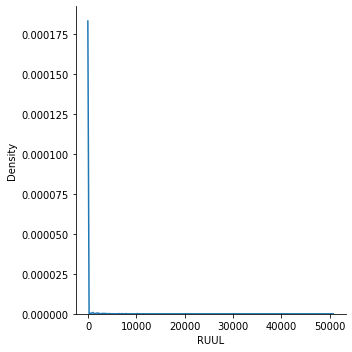

In [ ]:
sns.displot(df_late, x='RUUL', kind='kde')

In [ ]:
df_late[(df_late['RUUL'] >= 0) & (df_late['RUUL'] <= 1)]['serious_delinquency'].describe()

count    139027.000000
mean          0.059499
std           0.236558
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: serious_delinquency, dtype: float64

In [ ]:
df_late[df_late['RUUL'] > 1]['serious_delinquency'].describe()

count    3210.000000
mean        0.371963
std         0.483404
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: serious_delinquency, dtype: float64

Dapat dilihat bahwa jumlah orang yang memiliki rasio hutang dibagi limit kredit (RUUL) dengan nilai >=0 dan <=1 berjumlah 139.027 orang. 
<br>
Terdapat 3210 orang yg memiliki RUUL > 1 bahkan mencapai 50.000. 
<br>
Agar data konsisten, data dengan RUUL > 1 akan dihapus.

In [ ]:
# Remove RUUL > 1
df_ruul = df_late.drop(df_late[df_late['RUUL'] > 1].index)
df_ruul

,serious_delinquency,age,num_of_dependents,monthly_income,RUUL,debt_ratio,num_of_open_loans,num_of_real_estate_loans,late_30-59_days,late_60-89_days,late_90_days
1,1,45,2.0,9120.0,0.766127,0.802982,13,6,2,0,0
2,0,40,1.0,2600.0,0.957151,0.121876,4,0,0,0,0
3,0,38,0.0,3042.0,0.658180,0.085113,2,0,1,0,1
4,0,30,0.0,3300.0,0.233810,0.036050,5,0,0,0,0
5,0,49,0.0,63588.0,0.907239,0.024926,7,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,50,0.0,3400.0,0.385742,0.404293,7,0,0,0,0
149996,0,74,0.0,2100.0,0.040674,0.225131,4,1,0,0,0
149997,0,44,2.0,5584.0,0.299745,0.716562,4,1,0,0,0
149999,0,30,0.0,5716.0,0.000000,0.000000,4,0,0,0,0


**Missing Value**

In [ ]:
df_ruul.isnull().sum()

serious_delinquency             0
age                             0
num_of_dependents            3336
monthly_income              22052
RUUL                            0
debt_ratio                      0
num_of_open_loans               0
num_of_real_estate_loans        0
late_30-59_days                 0
late_60-89_days                 0
late_90_days                    0
dtype: int64

Kolom `monthly_income` dan `num_of_dependents` memiliki missing values yg cukup banyak, dan dapat diisi dengan nilai median dari masing-masing kolom.

In [ ]:
df_ruul['monthly_income']    = df_ruul['monthly_income'].fillna(df_ruul['monthly_income'].median())
df_ruul['num_of_dependents'] = df_ruul['num_of_dependents'].fillna(df_ruul['num_of_dependents'].median())

In [ ]:
df_ruul['age'].value_counts().sort_index()

0        1
21     157
22     379
23     596
24     768
      ... 
102      3
103      3
105      1
107      1
109      2
Name: age, Length: 86, dtype: int64

In [ ]:
# Drop age = 0
df_age = df_ruul.drop(df_ruul[df_ruul['age'] == 0].index)

In [ ]:
df_last = df_age.copy()

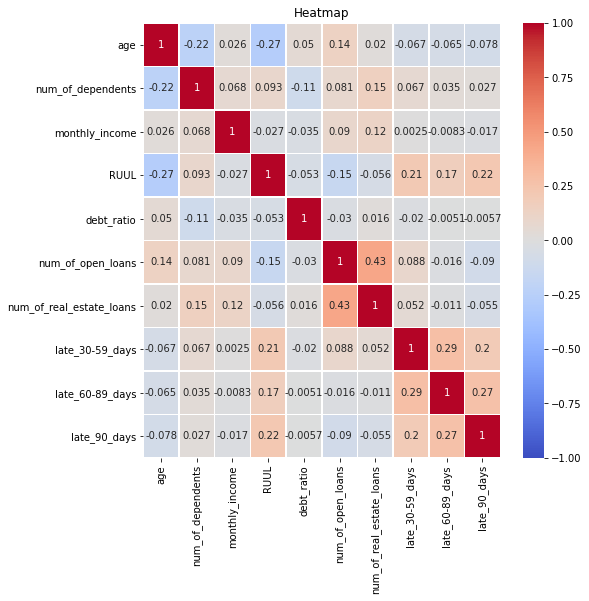

In [ ]:
heat_col = ['age', 'num_of_dependents', 'monthly_income',
            'RUUL', 'debt_ratio', 'num_of_open_loans', 'num_of_real_estate_loans',
            'late_30-59_days', 'late_60-89_days', 'late_90_days']

plt.figure(figsize=(8,8))
plt.title('Heatmap')
corr = df_last[heat_col].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
            linewidths=.5, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

**Weight of Evidence (WoE) dan Information Value (IV)**

*Binning* dilakukan untuk masing-masing kolom sebelum perhitungan WoE dan IV.

In [ ]:
age_bins = [20, 30, 40, 50, 60, 70, 80, 90, 130]
age_labels = ['A.20-30', 'A.30-40', 'A.40-50', 'A.50-60', 'A.60-70', 'A.70-80', 'A.80-90', 'A.90-130']
df_last['Age_binned'] = pd.cut(df_last['age'], bins=age_bins, labels=age_labels)

In [ ]:
dep_bins = [0, 0.9, 1.9, 2.9, 3.9, df_last['num_of_dependents'].max()]
dep_labels = ['DEP.0', 'DEP.1', 'DEP.2', 'DEP.3', 'DEP.4']
df_last['Num of Dependents_binned'] = pd.cut(df_last['num_of_dependents'], bins=dep_bins, labels=dep_labels, include_lowest=True)

In [ ]:
mi_bins = [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, df_last['monthly_income'].max()]
mi_labels = ['MI.0-2k', 'MI.2k-4k', 'MI.4k-6k', 'MI.6k-8k', 'MI.8k-10k', 'MI.10k-12k', 'MI.12k-14k', 'MI.14k-1616k', 'MI.>16k']
df_last['Monthly Income_binned'] = pd.cut(df_last['monthly_income'], bins=mi_bins, labels=mi_labels, include_lowest=True)

In [ ]:
RUUL_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
RUUL_labels = ['RUUL.0-0.2', 'RUUL.0.2-0.4', 'RUUL.0.4-0.6', 'RUUL.0.6-0.8', 'RUUL.0.8-1']
df_last['RUUL_binned'] = pd.cut(df_last['RUUL'], bins=RUUL_bins, labels=RUUL_labels, include_lowest=True)

In [ ]:
dr_bins = [0.0, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 2500]
dr_labels = ['DR.0-0.2', 'DR.0.2-0.5', 'DR.0.5-1', 'DR.1-2', 'DR.2-5', 'DR.5-10', 'DR.10-20', 'DR.20-50', 'DR.50-100', 'DR.>100']
df_last['Debt Ratio_binned'] = pd.cut(df_last['debt_ratio'], bins=dr_bins, labels=dr_labels, include_lowest=True)

In [ ]:
open_loans_bins = [0, 0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9, 10.9, df_last['num_of_open_loans'].max()]
open_loans_labels = ['OPEN.0', 'OPEN.1', 'OPEN.2', 'OPEN.3', 'OPEN.4', 'OPEN.5', 'OPEN.6', 'OPEN.7', 'OPEN.8', 'OPEN.9', 'OPEN.10', 'OPEN.>10']
df_last['Open Loans_binned'] = pd.cut(df_last['num_of_open_loans'], bins=open_loans_bins, labels=open_loans_labels, include_lowest=True)

In [ ]:
real_estate_bins = [0, 0.9, 1.9, 2.9, 3.9, df_last['num_of_real_estate_loans'].max()]
real_estate_labels = ['ESTATE.0', 'ESTATE.1', 'ESTATE.2', 'ESTATE.3', 'ESTATE.>3']
df_last['Real Estate_binned'] = pd.cut(df_last['num_of_real_estate_loans'], bins=real_estate_bins, labels=real_estate_labels, include_lowest=True)

In [ ]:
late_30_bins = [0, 0.9, 1.9, 2.9, 3.9, 4.9, 5.9, df_last['late_30-59_days'].max()]
late_30_labels = ['LATE30.0', 'LATE30.1', 'LATE30.2', 'LATE30.3', 'LATE30.4', 'LATE30.5', 'LATE30.>5']
df_last['Late 30-59 Days_binned'] = pd.cut(df_last['late_30-59_days'], bins=late_30_bins, labels=late_30_labels, include_lowest=True)

In [ ]:
late_60_bins = [0, 0.9, 1.9, 2.9, 3.9, 4.9, 5.9, df_last['late_60-89_days'].max()]
late_60_labels = ['LATE60.0', 'LATE60.1', 'LATE60.2', 'LATE60.3', 'LATE60.4', 'LATE60.5', 'LATE60.>5']
df_last['Late 60-89 Days_binned'] = pd.cut(df_last['late_60-89_days'], bins=late_60_bins, labels=late_60_labels, include_lowest=True)

In [ ]:
late_90_bins = [0, 0.9, 1.9, 2.9, 3.9, 4.9, 5.9, df_last['late_90_days'].max()]
late_90_labels = ['LATE90.0', 'LATE90.1', 'LATE90.2', 'LATE90.3', 'LATE90.4', 'LATE90.5', 'LATE90.>5']
df_last['Late 90 Days_binned'] = pd.cut(df_last['late_90_days'], bins=late_90_bins, labels=late_90_labels, include_lowest=True)

In [ ]:
df_last_woe = df_last.copy()
df_last_woe = df_last_woe.drop(['age', 'num_of_dependents', 'monthly_income',
                                'RUUL', 'debt_ratio', 'num_of_open_loans', 'num_of_real_estate_loans',
                                'late_30-59_days', 'late_60-89_days', 'late_90_days'], axis=1)
df_last_woe

,serious_delinquency,Age_binned,Num of Dependents_binned,Monthly Income_binned,RUUL_binned,Debt Ratio_binned,Open Loans_binned,Real Estate_binned,Late 30-59 Days_binned,Late 60-89 Days_binned,Late 90 Days_binned
1,1,A.40-50,DEP.2,MI.8k-10k,RUUL.0.6-0.8,DR.0.5-1,OPEN.>10,ESTATE.>3,LATE30.2,LATE60.0,LATE90.0
2,0,A.30-40,DEP.1,MI.2k-4k,RUUL.0.8-1,DR.0-0.2,OPEN.4,ESTATE.0,LATE30.0,LATE60.0,LATE90.0
3,0,A.30-40,DEP.0,MI.2k-4k,RUUL.0.6-0.8,DR.0-0.2,OPEN.2,ESTATE.0,LATE30.1,LATE60.0,LATE90.1
4,0,A.20-30,DEP.0,MI.2k-4k,RUUL.0.2-0.4,DR.0-0.2,OPEN.5,ESTATE.0,LATE30.0,LATE60.0,LATE90.0
5,0,A.40-50,DEP.0,MI.>16k,RUUL.0.8-1,DR.0-0.2,OPEN.7,ESTATE.1,LATE30.1,LATE60.0,LATE90.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,A.40-50,DEP.0,MI.2k-4k,RUUL.0.2-0.4,DR.0.2-0.5,OPEN.7,ESTATE.0,LATE30.0,LATE60.0,LATE90.0
149996,0,A.70-80,DEP.0,MI.2k-4k,RUUL.0-0.2,DR.0.2-0.5,OPEN.4,ESTATE.1,LATE30.0,LATE60.0,LATE90.0
149997,0,A.40-50,DEP.2,MI.4k-6k,RUUL.0.2-0.4,DR.0.5-1,OPEN.4,ESTATE.1,LATE30.0,LATE60.0,LATE90.0
149999,0,A.20-30,DEP.0,MI.4k-6k,RUUL.0-0.2,DR.0-0.2,OPEN.4,ESTATE.0,LATE30.0,LATE60.0,LATE90.0


Perhitungan WoE dan IV untuk masing-masing kolom

In [ ]:
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [ ]:
for col in df_last_woe.columns:
    if col == 'serious_delinquency': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df, iv = calculate_woe_iv(df_last_woe, col, 'serious_delinquency')
        print(df)
        print('IV score: {:.2f}'.format(iv))
        print('\n')

WoE and IV for column: Age_binned
      Value    All   Good   Bad  Distr_Good  Distr_Bad       WoE        IV
2   A.20-30  10013   9029   984    0.069053   0.118956 -0.543870  0.027140
1   A.30-40  22514  20595  1919    0.157510   0.231987 -0.387197  0.028838
0   A.40-50  32092  29690  2402    0.227068   0.290377 -0.245933  0.015570
4   A.50-60  31848  30044  1804    0.229775   0.218085  0.052215  0.000610
5   A.60-70  25425  24630   795    0.188369   0.096107  0.672937  0.062086
3   A.70-80  12271  11997   274    0.091752   0.033124  1.018842  0.059733
7  A.90-130    482    472    10    0.003610   0.001209  1.093953  0.002627
6   A.80-90   4381   4297    84    0.032863   0.010155  1.174414  0.026669
IV score: 0.22


WoE and IV for column: Num of Dependents_binned
   Value    All   Good   Bad  Distr_Good  Distr_Bad       WoE        IV
4  DEP.4   3602   3275   327    0.025047   0.039531 -0.456328  0.006609
3  DEP.3   8861   8138   723    0.062239   0.087403 -0.339551  0.008545
0  DEP.2  

Pemeringkatan nilai IV untuk masing-masing kolom

In [ ]:
df_IV =  pd.DataFrame({'Columns':
                       ['age_binned', 'debt_ratio_binned', 'monthly_income_binned', 'RUUL_binned',
                        'open_loans_binned', 'real_estate_binned', 'num_of_dependents_binned',
                        'late_30-59_days_binned', 'late_60-89_days_binned', 'late_90_days_binned'],
                       'IV':
                       [calculate_woe_iv(df_last_woe, 'Age_binned', 'serious_delinquency')[1],
                        calculate_woe_iv(df_last_woe, 'Debt Ratio_binned', 'serious_delinquency')[1],
                        calculate_woe_iv(df_last_woe, 'Monthly Income_binned', 'serious_delinquency')[1],
                        calculate_woe_iv(df_last_woe, 'RUUL_binned', 'serious_delinquency')[1],
                        calculate_woe_iv(df_last_woe, 'Open Loans_binned', 'serious_delinquency')[1],
                        calculate_woe_iv(df_last_woe, 'Real Estate_binned', 'serious_delinquency')[1],
                        calculate_woe_iv(df_last_woe, 'Num of Dependents_binned', 'serious_delinquency')[1],
                        calculate_woe_iv(df_last_woe, 'Late 30-59 Days_binned', 'serious_delinquency')[1],
                        calculate_woe_iv(df_last_woe, 'Late 60-89 Days_binned', 'serious_delinquency')[1],
                        calculate_woe_iv(df_last_woe, 'Late 90 Days_binned', 'serious_delinquency')[1]],                      
                       }).sort_values('IV', ascending=False)
df_IV

,Columns,IV
3,RUUL_binned,0.936442
9,late_90_days_binned,0.800325
7,late_30-59_days_binned,0.637345
8,late_60-89_days_binned,0.500543
0,age_binned,0.223274
4,open_loans_binned,0.099119
1,debt_ratio_binned,0.081930
2,monthly_income_binned,0.051849
5,real_estate_binned,0.050661
6,num_of_dependents_binned,0.037478


**Machine Learning**

Training dengan menggunakan algoritma `LogisticRegression` dan `K-Fold` cross validation dengan nilai `k`=5, menggunakan 7 kolom dengan nilai IV tertinggi.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

In [ ]:
# Kolom input menggunakan 7 kolom dengan nilai IV tertinggi
X = df_last_woe[['Age_binned', 'RUUL_binned', 'Debt Ratio_binned', 'Open Loans_binned',
                 'Late 30-59 Days_binned', 'Late 60-89 Days_binned', 'Late 90 Days_binned']]
X = pd.get_dummies(X)
# Kolom target
y = df_last_woe['serious_delinquency']
features = ['Age_binned', 'RUUL_binned', 'Debt Ratio_binned', 'Open Loans_binned',
            'Late 30-59 Days_binned', 'Late 60-89 Days_binned', 'Late 90 Days_binned']                

In [ ]:
reg = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_list = [reg]

In [ ]:
kf = KFold(n_splits=5, random_state=45, shuffle=True)

mdl = []
fold = []
acc_scr = []
rec_scr = []
prc_scr = []
f1_scr = []
ra_scr = []

for i, (train_index, test_index) in enumerate(kf.split(df_last_woe)):
    train_set = df_last_woe.iloc[train_index,:]
    test_set  = df_last_woe.iloc[test_index,:]
    print('Fold: ', i+1)
    
    for clf in clf_list:
        model = clf.__class__.__name__
        X_train = pd.get_dummies(train_set[features])
        y_train = train_set['serious_delinquency']
        X_test = pd.get_dummies(test_set[features])
        y_test = test_set['serious_delinquency']
        
        clf.fit(X_train, y_train) 
        y_pred = clf.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        prc = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        ra = roc_auc_score(y_test, y_pred)
        
        fold.append(i+1)
        acc_scr.append(acc)
        rec_scr.append(rec)
        prc_scr.append(prc)
        f1_scr.append(f1)
        ra_scr.append(ra)
        mdl.append(model)
        print(model)

print('Training selesai')          

Fold:  1
LogisticRegression
Fold:  2
LogisticRegression
Fold:  3
LogisticRegression
Fold:  4
LogisticRegression
Fold:  5
LogisticRegression
Training selesai


Plotting nilai accuracy, recall, precision, F1, dan ROC-AUC untuk masing-masing fold

In [ ]:
df_score = pd.DataFrame({'Fold':fold, 'Accuracy Score':acc_scr,'Recall Score':rec_scr, 'Precision Score':prc_scr,
                         'F1 Score':f1_scr, 'ROC-AUC Score':ra_scr})
df_score_melt = df_score.melt('Fold', var_name='cols',  value_name='Score')

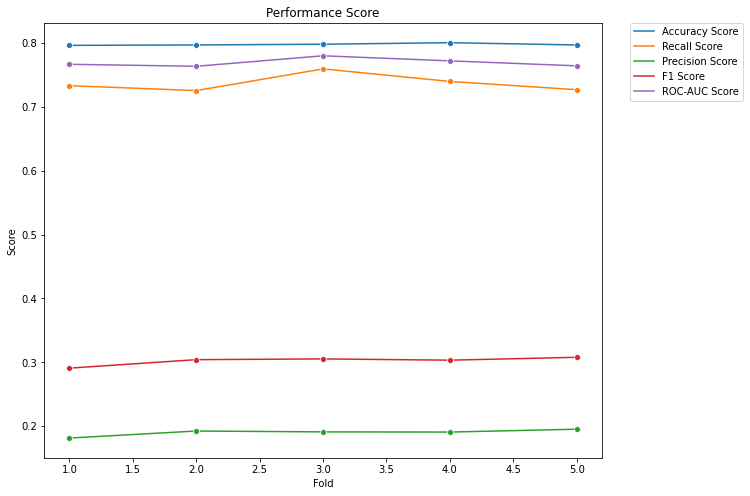

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Performance Score')
sns.lineplot(x="Fold", y="Score", hue='cols', data=df_score_melt, style='cols', marker='o', dashes=False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
y_pred = reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     26077
           1       0.20      0.73      0.31      1728

    accuracy                           0.80     27805
   macro avg       0.59      0.76      0.59     27805
weighted avg       0.93      0.80      0.85     27805



**Credit Scorecard**

Pembuatan Scorecard untuk melakukan valuasi nilai credit masing-masing calon nasabah, menggunakan koefisien regresi logistik untuk masing-masing fitur.

In [ ]:
df_scorecard = pd.concat([pd.DataFrame(X_train.columns, columns=['Feature']),
                          np.transpose(pd.DataFrame(reg.coef_))], axis=1).rename(columns={0:'Coefficient'})
df_scorecard.loc[0] = ['Intercept', reg.intercept_[0]]   
df_scorecard['Original feature name'] = df_scorecard['Feature'].str.split('_').str[0]                  
df_scorecard.head(2)                  

,Feature,Coefficient,Original feature name
0,Intercept,3.527866,Intercept
1,Age_binned_A.30-40,0.333576,Age


In [ ]:
min_score = 300
max_score = 850

In [ ]:
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficient'].min().sum()
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficient'].max().sum()

df_scorecard['Score - Calculation'] = df_scorecard['Coefficient'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)
df_scorecard.loc[0, 'Score - Calculation'] = ((df_scorecard.loc[0,'Coefficient'] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score
df_scorecard['Score - Final'] = df_scorecard['Score - Calculation'].round()

In [ ]:
df_scorecard

,Feature,Coefficient,Original feature name,Score - Calculation,Score - Final
0,Intercept,3.527866,Intercept,629.712076,630.0
1,Age_binned_A.30-40,0.333576,Age,17.727751,18.0
2,Age_binned_A.40-50,0.190173,Age,10.106669,10.0
3,Age_binned_A.50-60,0.015090,Age,0.801971,1.0
4,Age_binned_A.60-70,-0.322192,Age,-17.122746,-17.0
5,Age_binned_A.70-80,-0.404409,Age,-21.492086,-21.0
6,Age_binned_A.80-90,-0.180823,Age,-9.609758,-10.0
7,Age_binned_A.90-130,-0.166010,Age,-8.822491,-9.0
8,RUUL_binned_RUUL.0-0.2,-0.921076,RUUL,-48.950095,-49.0
9,RUUL_binned_RUUL.0.2-0.4,-0.375408,RUUL,-19.950875,-20.0


In [ ]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)

300.0
851.0


In [ ]:
scorecard_scores = df_scorecard['Score - Final']
scorecard_scores = scorecard_scores.values.reshape(56, 1)
print(scorecard_scores.shape)
print(X_test.shape)

(56, 1)
(27805, 56)


Perkalian dot-product antara masing-masing data pada X_test dengan kolom scorecard

In [ ]:
X_test_credit_score = X_test.dot(scorecard_scores).rename(columns={0:'Credit Score'})
X_test_credit_score.sample(10)

,Credit Score
134483,630.0
77361,-182.0
16918,-196.0
60525,-272.0
84816,-217.0
130618,-243.0
141025,-213.0
25906,-241.0
116247,-287.0
14656,-87.0
